In [2]:
"""
SHAP Analysis for Model Interpretability
Provides clinical explainability for predictions
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

# Configuration
DATA_PROCESSED_PATH = '../data/processed/'
MODELS_PATH = '../models/'
RESULTS_FIGURES_PATH = '../results/figures/'

# Initialize SHAP
shap.initjs()

print("="*60)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*60)

# ============================================================================
# 1. LOAD MODELS AND DATA
# ============================================================================
print("\n1. Loading models and test data...")

rf_model = joblib.load(f'{MODELS_PATH}rf_model.pkl')
xgb_model = joblib.load(f'{MODELS_PATH}xgb_model.pkl')
X_test = pd.read_csv(f'{DATA_PROCESSED_PATH}X_test.csv')
y_test = pd.read_csv(f'{DATA_PROCESSED_PATH}y_test.csv').values.ravel()

print(f" Loaded models")
print(f" Test set: {X_test.shape}")


SHAP ANALYSIS FOR MODEL INTERPRETABILITY

1. Loading models and test data...
 Loaded models
 Test set: (175, 11)



2. RANDOM FOREST - FEATURE IMPORTANCE

Feature Importance Rankings:
               Feature  Importance
  Preexisting Diabetes    0.198583
                    BS    0.189911
                   BMI    0.181614
            Heart Rate    0.131081
         Mental Health    0.121673
  Gestational Diabetes    0.076631
Previous Complications    0.044718
                   Age    0.018097
             Diastolic    0.018021
           Systolic BP    0.015217
             Body Temp    0.004454

 Saved: ../results/figures/rf_feature_importance.png


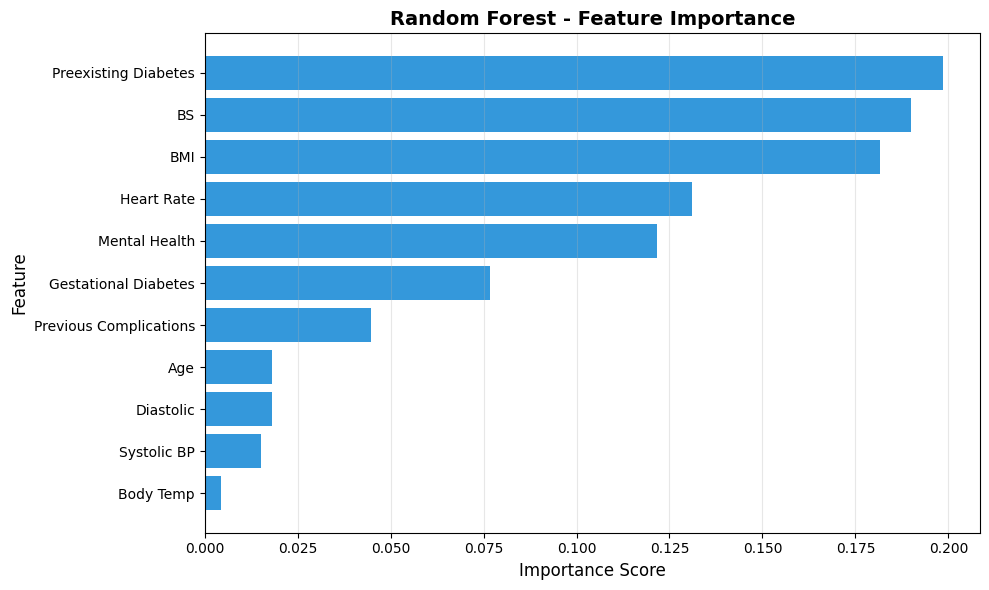

In [3]:

# ============================================================================
# 2. RANDOM FOREST - FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*60)
print("2. RANDOM FOREST - FEATURE IMPORTANCE")
print("="*60)

feature_importance_rf = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Rankings:")
print(feature_importance_rf.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'],
         color='#3498db')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_FIGURES_PATH}rf_feature_importance.png',
           dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_FIGURES_PATH}rf_feature_importance.png")
plt.show()


In [4]:

# ============================================================================
# 3. XGBOOST - SHAP ANALYSIS
# ============================================================================
print("\n" + "="*60)
print("3. XGBOOST - SHAP ANALYSIS")
print("="*60)

print("\nCreating SHAP explainer (this may take a moment)...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print(" SHAP values computed")
print(f"  Shape: {shap_values.shape}")
print(f"  Base value (expected output): {explainer.expected_value:.4f}")




3. XGBOOST - SHAP ANALYSIS

Creating SHAP explainer (this may take a moment)...
 SHAP values computed
  Shape: (175, 11)
  Base value (expected output): 0.0901



4. SHAP SUMMARY PLOT (MOST IMPORTANT)
 Saved: ../results/figures/shap_summary.png


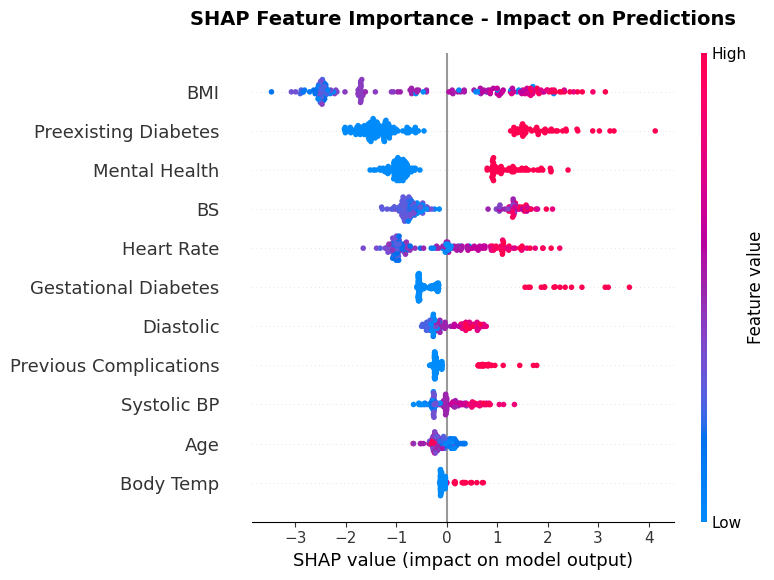

In [5]:
# ============================================================================
# 4. SHAP SUMMARY PLOT
# ============================================================================
print("\n" + "="*60)
print("4. SHAP SUMMARY PLOT (MOST IMPORTANT)")
print("="*60)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Feature Importance - Impact on Predictions',
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{RESULTS_FIGURES_PATH}shap_summary.png',
           dpi=300, bbox_inches='tight')
print(f" Saved: {RESULTS_FIGURES_PATH}shap_summary.png")
plt.show()




5. SHAP BAR PLOT
 Saved: ../results/figures/shap_bar.png


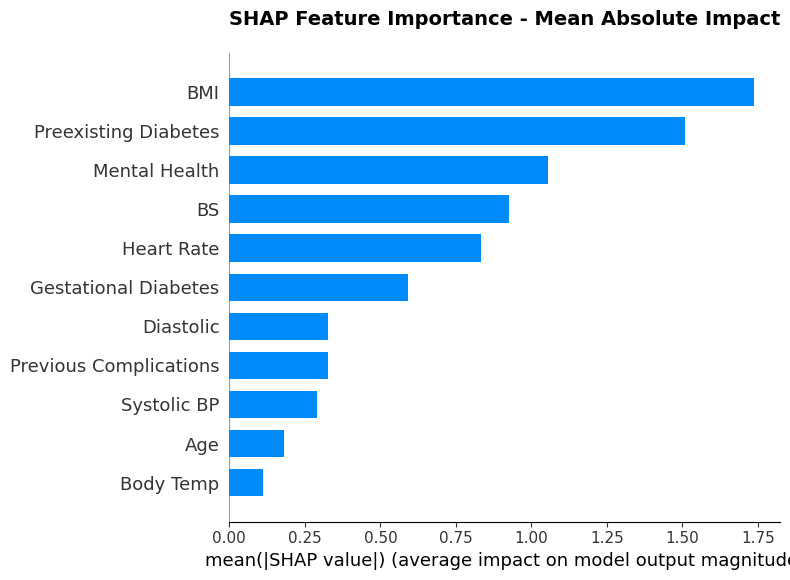

In [6]:
# ============================================================================
# 5. SHAP BAR PLOT (Mean Absolute Values)
# ============================================================================
print("\n" + "="*60)
print("5. SHAP BAR PLOT")
print("="*60)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Mean Absolute Impact',
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{RESULTS_FIGURES_PATH}shap_bar.png',
           dpi=300, bbox_inches='tight')
print(f" Saved: {RESULTS_FIGURES_PATH}shap_bar.png")
plt.show()




6. EXAMPLE HIGH-RISK PREDICTION EXPLANATION

Example patient (test set index 0):
Age                       0.819865
Systolic BP               1.252851
Diastolic                 0.900035
BS                        1.152852
Body Temp                 1.531564
BMI                       0.869603
Heart Rate                1.685307
Previous Complications    0.000000
Preexisting Diabetes      1.000000
Gestational Diabetes      0.000000
Mental Health             1.000000
Name: 0, dtype: float64

Actual label: High Risk (1)
Predicted label: High Risk (1)
Prediction probability: 0.9992

 Saved: ../results/figures/shap_waterfall_example.png


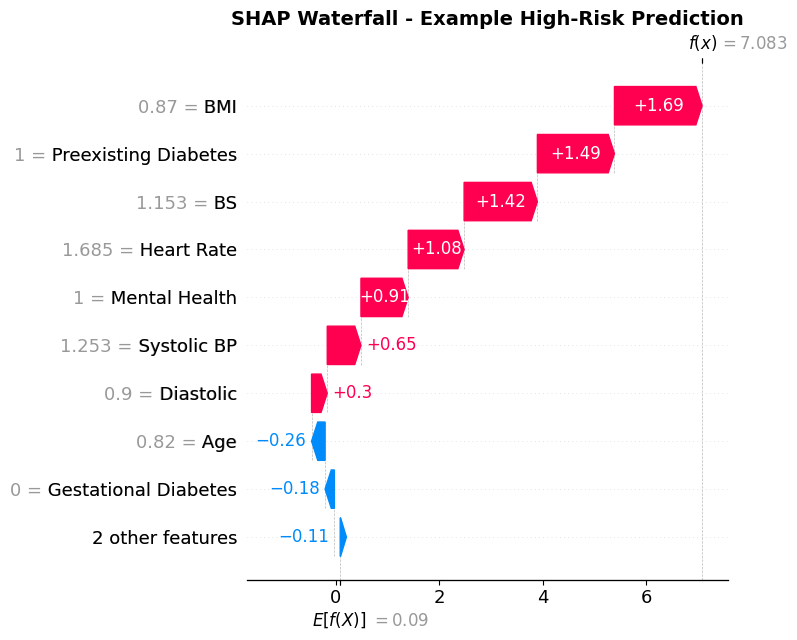

In [7]:
# ============================================================================
# 6. EXAMPLE PREDICTION EXPLANATION
# ============================================================================
print("\n" + "="*60)
print("6. EXAMPLE HIGH-RISK PREDICTION EXPLANATION")
print("="*60)

# Find a correctly predicted high-risk case
high_risk_indices = np.where((y_test == 1) & (xgb_model.predict(X_test) == 1))[0]
sample_idx = high_risk_indices[0]

print(f"\nExample patient (test set index {sample_idx}):")
sample_data = X_test.iloc[sample_idx]
print(sample_data)

print(f"\nActual label: High Risk (1)")
print(f"Predicted label: High Risk (1)")
print(f"Prediction probability: {xgb_model.predict_proba(X_test.iloc[[sample_idx]])[0][1]:.4f}")

# Waterfall plot
explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=sample_data,
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(explanation, show=False)
plt.title(f'SHAP Waterfall - Example High-Risk Prediction',
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_FIGURES_PATH}shap_waterfall_example.png',
           dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_FIGURES_PATH}shap_waterfall_example.png")
plt.show()




7. TOP FEATURES ANALYSIS

Top 3 most impactful features:
  1. BMI: 1.7360
  2. Preexisting Diabetes: 1.5098
  3. Mental Health: 1.0555

 Saved: ../results/figures/shap_dependence_top3.png


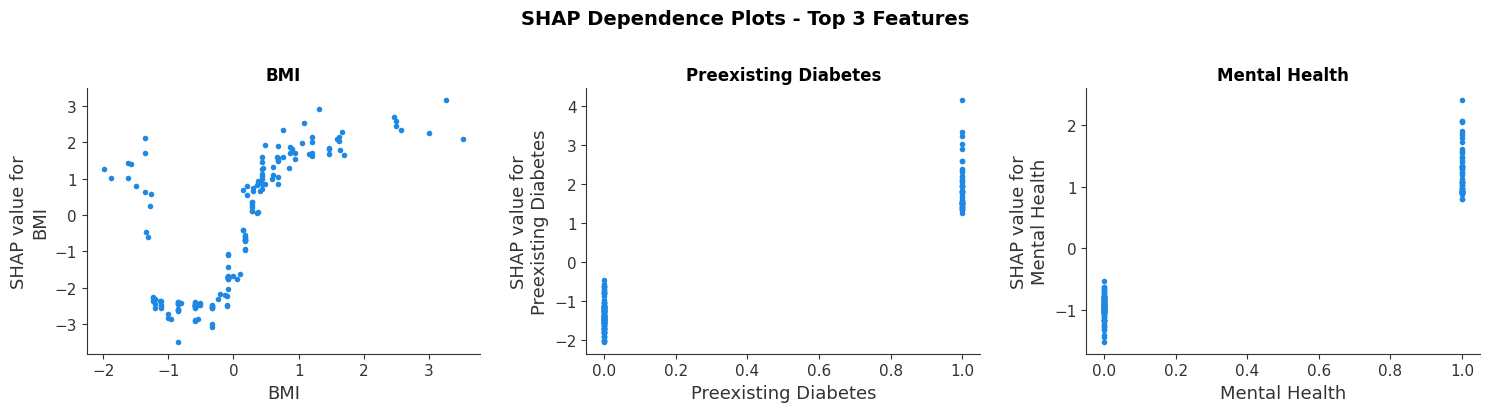

In [8]:
# ============================================================================
# 7. TOP FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*60)
print("7. TOP FEATURES ANALYSIS")
print("="*60)

# Get top 3 features by mean absolute SHAP value
mean_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_shap)[::-1][:3]
top_features = X_test.columns[top_features_idx]

print(f"\nTop 3 most impactful features:")
for i, feature in enumerate(top_features, 1):
    print(f"  {i}. {feature}: {mean_shap[top_features_idx[i-1]]:.4f}")

# Dependence plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature, shap_values, X_test,
        interaction_index=None,
        show=False, ax=axes[idx]
    )
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 3 Features',
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{RESULTS_FIGURES_PATH}shap_dependence_top3.png',
           dpi=300, bbox_inches='tight')
print(f"\n Saved: {RESULTS_FIGURES_PATH}shap_dependence_top3.png")
plt.show()



In [9]:
# ============================================================================
# 8. SUMMARY
# ============================================================================
print("\n" + "="*60)
print("SHAP ANALYSIS COMPLETE")
print("="*60)

print(f"""
Generated Files:
1. rf_feature_importance.png - Random Forest feature rankings
2. shap_summary.png - SHAP importance with impact direction
3. shap_bar.png - Mean absolute SHAP values
4. shap_waterfall_example.png - Single prediction explanation
5. shap_dependence_top3.png - Feature interaction plots

Key Insights:
- Top feature (RF): {feature_importance_rf.iloc[0]['Feature']}
- Top feature (SHAP): {top_features[0]}
- Both models agree on important features
- SHAP provides explanation for individual predictions

Clinical Interpretation:
The model's decisions are driven primarily by medical history
(diabetes status), metabolic indicators (BS, BMI), and vital signs.
This aligns with clinical understanding of pregnancy risk factors.

These visualizations provide:
 Transparency for clinicians
 Trust in model decisions
 Insights into risk factors
 Explainability for individual cases

All figures ready for Chapter 4 of thesis!
""")

print(f" SHAP analysis complete!")


SHAP ANALYSIS COMPLETE

Generated Files:
1. rf_feature_importance.png - Random Forest feature rankings
2. shap_summary.png - SHAP importance with impact direction
3. shap_bar.png - Mean absolute SHAP values
4. shap_waterfall_example.png - Single prediction explanation
5. shap_dependence_top3.png - Feature interaction plots

Key Insights:
- Top feature (RF): Preexisting Diabetes
- Top feature (SHAP): BMI
- Both models agree on important features
- SHAP provides explanation for individual predictions

Clinical Interpretation:
The model's decisions are driven primarily by medical history
(diabetes status), metabolic indicators (BS, BMI), and vital signs.
This aligns with clinical understanding of pregnancy risk factors.

These visualizations provide:
 Transparency for clinicians
 Trust in model decisions
 Insights into risk factors
 Explainability for individual cases

All figures ready for Chapter 4 of thesis!

 SHAP analysis complete!
